In [1]:
import os
import random
from collections import defaultdict
from enum import Enum
from typing import Tuple, List

import numpy as np
import torch
from PIL import Image
from torch.utils.data import Dataset, Subset, random_split
from torchvision.transforms import Resize, ToTensor, Normalize, Compose, CenterCrop, ColorJitter, Pad

IMG_EXTENSIONS = [
    ".jpg", ".JPG", ".jpeg", ".JPEG", ".png",
    ".PNG", ".ppm", ".PPM", ".bmp", ".BMP",
]

def is_image_file(filename):
    return any(filename.endswith(extension) for extension in IMG_EXTENSIONS)


class BaseAugmentation:
    def __init__(self, resize, mean, std, **args):
        self.transform = Compose([
            Resize(resize, Image.BILINEAR),
            ToTensor(),
            Normalize(mean=mean, std=std),
        ])

    def __call__(self, image):
        return self.transform(image)


class AddGaussianNoise(object):
    """
        transform 에 없는 기능들은 이런식으로 __init__, __call__, __repr__ 부분을
        직접 구현하여 사용할 수 있습니다.
    """

    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean

    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean

    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)


class CustomAugmentation:
    def __init__(self, resize, mean, std, **args):
        self.transform = Compose([
            CenterCrop((320, 256)),
            Resize(resize, Image.BILINEAR),
            ColorJitter(0.1, 0.1, 0.1, 0.1),
            ToTensor(),
            Normalize(mean=mean, std=std),
            AddGaussianNoise()
        ])

    def __call__(self, image):
        return self.transform(image)


class MyAugmentationCenter:
    """
    가운데만 크롭
    """
    def __init__(self, resize, mean, std, **args):
        self.transform = Compose([
            CenterCrop((256, 256)),
            Resize(resize, Image.BILINEAR),
            ToTensor(),
            Normalize(mean=mean, std=std),
        ])

    def __call__(self, image):
        return self.transform(image)

class MyAugmentationBust:
    """
    흉상부분만 Crop
    """
    def __init__(self, resize, mean, std, **args):
        self.transform = Compose([
            Pad((114,0,114,114)),
            CenterCrop((360, 360)),
            Resize(resize, Image.BILINEAR),
            ToTensor(),
            Normalize(mean=mean, std=std),
        ])

    def __call__(self, image):
        return self.transform(image)



class MaskLabels(int, Enum):
    MASK = 0
    INCORRECT = 1
    NORMAL = 2


class GenderLabels(int, Enum):
    MALE = 0
    FEMALE = 1

    @classmethod
    def from_str(cls, value: str) -> int:
        value = value.lower()
        if value == "male":
            return cls.MALE
        elif value == "female":
            return cls.FEMALE
        else:
            raise ValueError(f"Gender value should be either 'male' or 'female', {value}")


class AgeLabels(int, Enum):
    YOUNG = 0
    MIDDLE = 1
    OLD = 2

    @classmethod
    def from_number(cls, value: str) -> int:
        try:
            value = int(value)
        except Exception:
            raise ValueError(f"Age value should be numeric, {value}")

        if value < 30:
            return cls.YOUNG
        elif value < 60:
            return cls.MIDDLE
        else:
            return cls.OLD


class MaskBaseDataset(Dataset):
    num_classes = 3 * 2 * 3

    _file_names = {
        "mask1": MaskLabels.MASK,
        "mask2": MaskLabels.MASK,
        "mask3": MaskLabels.MASK,
        "mask4": MaskLabels.MASK,
        "mask5": MaskLabels.MASK,
        "incorrect_mask": MaskLabels.INCORRECT,
        "normal": MaskLabels.NORMAL
    }

    def __init__(self, data_dir, mean=(0.548, 0.504, 0.479), std=(0.237, 0.247, 0.246), val_ratio=0.2):
        self.data_dir = data_dir
        self.mean = mean
        self.std = std
        self.val_ratio = val_ratio

        self.image_paths = []
        self.mask_labels = []
        self.gender_labels = []
        self.age_labels = []

        self.transform = None
        self.setup()
        self.calc_statistics()

    def setup(self):
        profiles = os.listdir(self.data_dir)
        for profile in profiles:
            if profile.startswith("."):  # "." 로 시작하는 파일은 무시합니다
                continue

            img_folder = os.path.join(self.data_dir, profile)
            for file_name in os.listdir(img_folder):
                _file_name, ext = os.path.splitext(file_name)
                if _file_name not in self._file_names:  # "." 로 시작하는 파일 및 invalid 한 파일들은 무시합니다
                    continue

                img_path = os.path.join(self.data_dir, profile, file_name)  # (resized_data, 000004_male_Asian_54, mask1.jpg)
                mask_label = self._file_names[_file_name]

                id, gender, race, age = profile.split("_")
                gender_label = GenderLabels.from_str(gender)
                age_label = AgeLabels.from_number(age)

                self.image_paths.append(img_path)
                self.mask_labels.append(mask_label)
                self.gender_labels.append(gender_label)
                self.age_labels.append(age_label)

    def calc_statistics(self):
        has_statistics = self.mean is not None and self.std is not None
        if not has_statistics:
            print("[Warning] Calculating statistics... It can take a long time depending on your CPU machine")
            sums = []
            squared = []
            for image_path in self.image_paths[:3000]:
                image = np.array(Image.open(image_path)).astype(np.int32)
                sums.append(image.mean(axis=(0, 1)))
                squared.append((image ** 2).mean(axis=(0, 1)))

            self.mean = np.mean(sums, axis=0) / 255
            self.std = (np.mean(squared, axis=0) - self.mean ** 2) ** 0.5 / 255

    def set_transform(self, transform):
        self.transform = transform

    def __getitem__(self, index):
        assert self.transform is not None, ".set_tranform 메소드를 이용하여 transform 을 주입해주세요"

        image = self.read_image(index)
        mask_label = self.get_mask_label(index)
        gender_label = self.get_gender_label(index)
        age_label = self.get_age_label(index)
        multi_class_label = self.encode_multi_class(mask_label, gender_label, age_label)

        image_transform = self.transform(image)
        return image_transform, multi_class_label

    def __len__(self):
        return len(self.image_paths)

    def get_mask_label(self, index) -> MaskLabels:
        return self.mask_labels[index]

    def get_gender_label(self, index) -> GenderLabels:
        return self.gender_labels[index]

    def get_age_label(self, index) -> AgeLabels:
        return self.age_labels[index]

    def read_image(self, index):
        image_path = self.image_paths[index]
        return Image.open(image_path)

    @staticmethod
    def encode_multi_class(mask_label, gender_label, age_label) -> int:
        return mask_label * 6 + gender_label * 3 + age_label

    @staticmethod
    def decode_multi_class(multi_class_label) -> Tuple[MaskLabels, GenderLabels, AgeLabels]:
        mask_label = (multi_class_label // 6) % 3
        gender_label = (multi_class_label // 3) % 2
        age_label = multi_class_label % 3
        return mask_label, gender_label, age_label

    @staticmethod
    def denormalize_image(image, mean, std):
        img_cp = image.copy()
        img_cp *= std
        img_cp += mean
        img_cp *= 255.0
        img_cp = np.clip(img_cp, 0, 255).astype(np.uint8)
        return img_cp

    def split_dataset(self) -> Tuple[Subset, Subset]:
        """
        데이터셋을 train 과 val 로 나눕니다,
        pytorch 내부의 torch.utils.data.random_split 함수를 사용하여
        torch.utils.data.Subset 클래스 둘로 나눕니다.
        구현이 어렵지 않으니 구글링 혹은 IDE (e.g. pycharm) 의 navigation 기능을 통해 코드를 한 번 읽어보는 것을 추천드립니다^^
        """
        n_val = int(len(self) * self.val_ratio)
        n_train = len(self) - n_val
        train_set, val_set = random_split(self, [n_train, n_val])
        return train_set, val_set


class MaskSplitByProfileDataset(MaskBaseDataset):
    """
        train / val 나누는 기준을 이미지에 대해서 random 이 아닌
        사람(profile)을 기준으로 나눕니다.
        구현은 val_ratio 에 맞게 train / val 나누는 것을 이미지 전체가 아닌 사람(profile)에 대해서 진행하여 indexing 을 합니다
        이후 `split_dataset` 에서 index 에 맞게 Subset 으로 dataset 을 분기합니다.
    """

    def __init__(self, data_dir, mean=(0.548, 0.504, 0.479), std=(0.237, 0.247, 0.246), val_ratio=0.2):
        self.indices = defaultdict(list)
        super().__init__(data_dir, mean, std, val_ratio)

    @staticmethod
    def _split_profile(profiles, val_ratio):
        length = len(profiles)
        n_val = int(length * val_ratio)

        val_indices = set(random.choices(range(length), k=n_val))
        train_indices = set(range(length)) - val_indices
        return {
            "train": train_indices,
            "val": val_indices
        }

    def setup(self):
        profiles = os.listdir(self.data_dir)
        profiles = [profile for profile in profiles if not profile.startswith(".")]
        split_profiles = self._split_profile(profiles, self.val_ratio)

        cnt = 0
        for phase, indices in split_profiles.items():
            for _idx in indices:
                profile = profiles[_idx]
                img_folder = os.path.join(self.data_dir, profile)
                for file_name in os.listdir(img_folder):
                    _file_name, ext = os.path.splitext(file_name)
                    if _file_name not in self._file_names:  # "." 로 시작하는 파일 및 invalid 한 파일들은 무시합니다
                        continue

                    img_path = os.path.join(self.data_dir, profile, file_name)  # (resized_data, 000004_male_Asian_54, mask1.jpg)
                    mask_label = self._file_names[_file_name]

                    id, gender, race, age = profile.split("_")
                    gender_label = GenderLabels.from_str(gender)
                    age_label = AgeLabels.from_number(age)

                    self.image_paths.append(img_path)
                    self.mask_labels.append(mask_label)
                    self.gender_labels.append(gender_label)
                    self.age_labels.append(age_label)

                    self.indices[phase].append(cnt)
                    cnt += 1

    def split_dataset(self) -> List[Subset]:
        return [Subset(self, indices) for phase, indices in self.indices.items()]


class TestDataset(Dataset):
    def __init__(self, img_paths, resize, mean=(0.548, 0.504, 0.479), std=(0.237, 0.247, 0.246)):
        self.img_paths = img_paths
        self.transform = Compose([
            Resize(resize, Image.BILINEAR),
            ToTensor(),
            Normalize(mean=mean, std=std),
        ])

    def __getitem__(self, index):
        image = Image.open(self.img_paths[index])

        if self.transform:
            image = self.transform(image)
        return image

    def __len__(self):
        return len(self.img_paths)


In [18]:
import torch
from torchvision import models
import torch.nn as nn
import torch.nn.functional as F
import math

class ResNet18(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.resnet18 = models.resnet18(pretrained=True)
        self.resnet18.fc = nn.Linear(in_features=512, out_features = num_classes, bias= True) 
        # self.Linear_1 = nn.Linear(in_features=1000, out_features = num_classes)

        # initialize w & b
        torch.nn.init.xavier_uniform_(self.resnet18.fc.weight)
        stdv = 1/math.sqrt(self.resnet18.fc.in_features)
        self.resnet18.fc.bias.data.uniform_(-stdv, stdv)

    def forward(self, x):
        x = self.resnet18(x)
        return x

In [19]:
import argparse
import glob
import json
import multiprocessing
import os
import random
import re
from importlib import import_module
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import f1_score

import torch
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

from dataset import MaskBaseDataset
from loss import create_criterion

In [38]:
def seed_everything(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if use multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']


def grid_image(np_images, gts, preds, n=16, shuffle=False):
    batch_size = np_images.shape[0]
    assert n <= batch_size

    choices = random.choices(range(batch_size), k=n) if shuffle else list(range(n))
    figure = plt.figure(figsize=(12, 18 + 2))  # cautions: hardcoded, 이미지 크기에 따라 figsize 를 조정해야 할 수 있습니다. T.T
    plt.subplots_adjust(top=0.8)  # cautions: hardcoded, 이미지 크기에 따라 top 를 조정해야 할 수 있습니다. T.T
    n_grid = int(np.ceil(n ** 0.5))
    tasks = ["mask", "gender", "age"]
    for idx, choice in enumerate(choices):
        gt = gts[choice].item()
        pred = preds[choice].item()
        image = np_images[choice]
        gt_decoded_labels = MaskBaseDataset.decode_multi_class(gt)
        pred_decoded_labels = MaskBaseDataset.decode_multi_class(pred)
        title = "\n".join([
            f"{task} - gt: {gt_label}, pred: {pred_label}"
            for gt_label, pred_label, task
            in zip(gt_decoded_labels, pred_decoded_labels, tasks)
        ])

        plt.subplot(n_grid, n_grid, idx + 1, title=title)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(image, cmap=plt.cm.binary)

    return figure


def increment_path(path, exist_ok=False):
    """ Automatically increment path, i.e. runs/exp --> runs/exp0, runs/exp1 etc.

    Args:
        path (str or pathlib.Path): f"{model_dir}/{args.name}".
        exist_ok (bool): whether increment path (increment if False).
    """
    path = Path(path)
    if (path.exists() and exist_ok) or (not path.exists()):
        return str(path)
    else:
        dirs = glob.glob(f"{path}*")
        matches = [re.search(rf"%s(\d+)" % path.stem, d) for d in dirs]
        i = [int(m.groups()[0]) for m in matches if m]
        n = max(i) + 1 if i else 2
        return f"{path}{n}"


In [39]:
data_dir = '/opt/ml/input/data/train/images'
model_dir = './model'
SAVE_NAME = 'TEST_MODEL'



#dataset.num_classes
NUN_CLASSES = 18

#args.seed
SEED = 42

#args.resize
RESIZE = [128, 96]

#args.batch_size
BATCH_SIZE = 64
#args.valid_batch_size
VALID_BATCH_SIZE = 1000

# args.lr
LEARNING_RATE = 1e-4
# args.lr_decay_step
lr_decay_step = 10


seed_everything(SEED)

save_dir = increment_path(os.path.join(model_dir, SAVE_NAME))

# -- settings
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")


#dataset_module = getattr(import_module("dataset"), args.dataset)  # default: MaskBaseDataset
dataset_module = MaskBaseDataset
dataset = dataset_module(
        data_dir=data_dir,
    )

num_classes = NUN_CLASSES


#transform_module = getattr(import_module("dataset"), args.augmentation)  # default: BaseAugmentation
transform_module = BaseAugmentation
transform = transform_module(
    resize=RESIZE,
    mean=dataset.mean,
    std=dataset.std,
)
dataset.set_transform(transform)


train_set, val_set = dataset.split_dataset()
##### DATA LOADEER
train_loader = DataLoader(
    train_set,
    batch_size=BATCH_SIZE,
    num_workers=multiprocessing.cpu_count() // 2,
    shuffle=True,
    pin_memory=use_cuda,
    drop_last=True,
)

val_loader = DataLoader(
    val_set,
    batch_size= VALID_BATCH_SIZE,
    num_workers=multiprocessing.cpu_count() // 2,
    shuffle=False,
    pin_memory=use_cuda,
    drop_last=True,
)

##### Model 정의 
# model_module = getattr(import_module("model"), args.model)  # default: BaseModel
model_module = ResNet18
model = model_module(
    num_classes=num_classes
).to(device)
model = torch.nn.DataParallel(model)




In [43]:
import torch.optim 

# criterion & optimizer
# args.criterion
criterion = create_criterion('cross_entropy') # default: cross_entropy
# args.optimizer
# opt_module = getattr(import_module("torch.optim"), args.optimizer)  # default: SGD
# opt_module = Adam
optimizer = torch.optim.Adam( filter(lambda p: p.requires_grad, model.parameters()),
    lr= LEARNING_RATE,
    weight_decay=5e-4
)
scheduler = StepLR(optimizer, lr_decay_step, gamma=0.5)

optimizer1 = torch.optim.Adam( filter(lambda p: p.requires_grad, model.parameters()),
    lr= LEARNING_RATE,
    weight_decay=5e-4
)
optimizer2 = torch.optim.Adam( filter(lambda p: p.requires_grad, model.parameters()),
    lr= LEARNING_RATE,
    weight_decay=5e-4
)


# logger = SummaryWriter(log_dir=save_dir)
# with open(os.path.join(save_dir, 'config.json'), 'w', encoding='utf-8') as f:
#     json.dump(vars(args), f, ensure_ascii=False, indent=4)


In [47]:
outs[,]

tensor([[ 3.2516,  2.1282,  0.0643,  ...,  0.5070, -3.9723, -3.6606],
        [11.4210, -0.3899, -1.4134,  ..., -3.0032, -2.5404, -2.7619],
        [ 0.3393,  0.3869, -1.2134,  ...,  2.5693, -3.5606, -2.9563],
        ...,
        [-4.9152, -2.6706, -0.0722,  ...,  3.5104, -2.1046, -4.0179],
        [-0.8275,  0.1435, -0.5232,  ..., -2.0460, -3.0107, -3.8062],
        [-0.9742, -0.1700, -1.4020,  ..., -0.7236,  1.8808,  0.2301]],
       device='cuda:0')

Epoch[ 0/ 2](  20/ 236) || training loss 0.1381 || training accuracy 96.09% || lr 0.0001
Epoch[ 0/ 2](  40/ 236) || training loss 0.1379 || training accuracy 96.72% || lr 0.0001
Epoch[ 0/ 2](  60/ 236) || training loss 0.1074 || training accuracy 97.03% || lr 0.0001
Epoch[ 0/ 2](  80/ 236) || training loss 0.1451 || training accuracy 95.94% || lr 0.0001
Epoch[ 0/ 2]( 100/ 236) || training loss 0.1197 || training accuracy 96.33% || lr 0.0001
Epoch[ 0/ 2]( 120/ 236) || training loss 0.08956 || training accuracy 97.34% || lr 0.0001
Epoch[ 0/ 2]( 140/ 236) || training loss 0.1052 || training accuracy 96.72% || lr 0.0001
Epoch[ 0/ 2]( 160/ 236) || training loss 0.1227 || training accuracy 96.09% || lr 0.0001
Epoch[ 0/ 2]( 180/ 236) || training loss 0.0841 || training accuracy 97.19% || lr 0.0001
Epoch[ 0/ 2]( 200/ 236) || training loss 0.1012 || training accuracy 96.72% || lr 0.0001
Epoch[ 0/ 2]( 220/ 236) || training loss 0.07859 || training accuracy 97.50% || lr 0.0001
Calculating validat

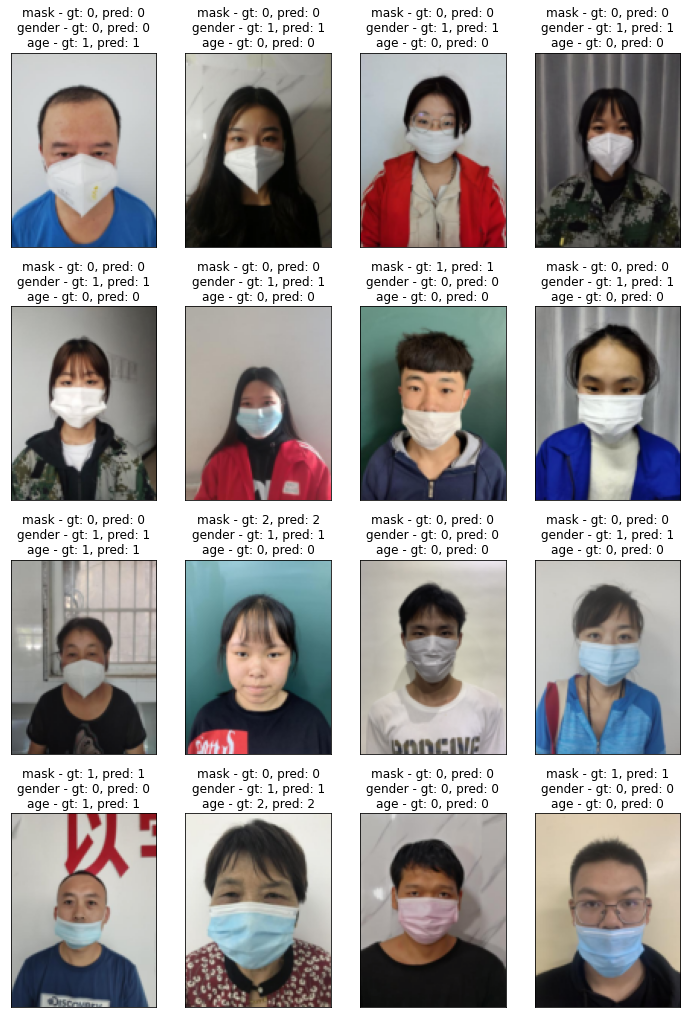

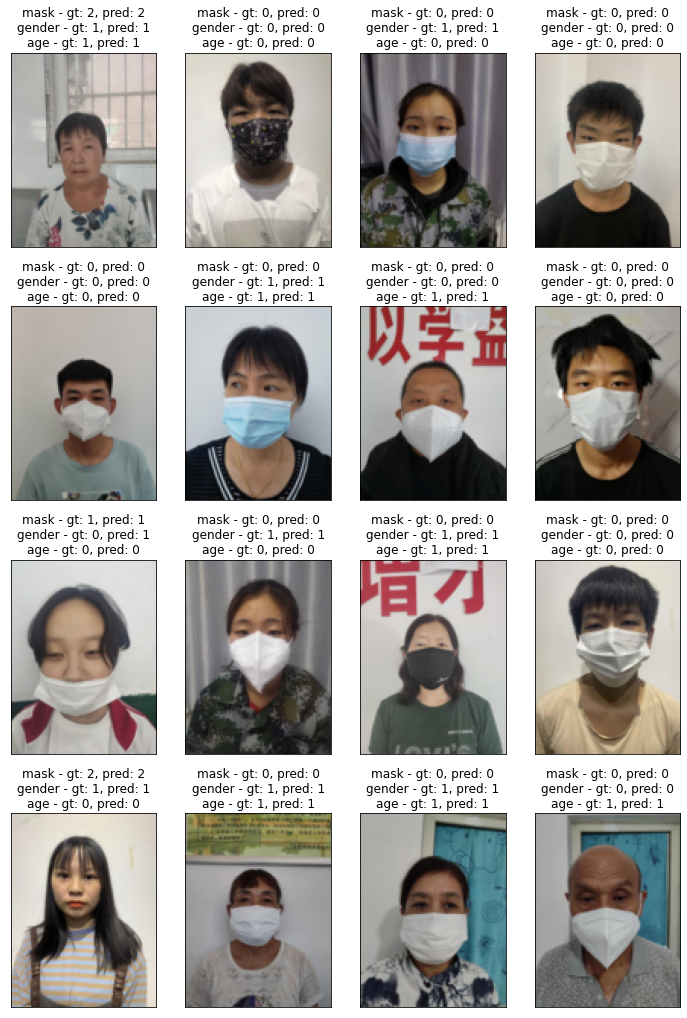

In [42]:
# args.epochs
EPOCHS = 2
# args.log_interval
log_interval = 20


best_val_acc = 0
best_val_loss = np.inf
# best_val_f1 = 0
for epoch in range(EPOCHS):
    # train loop
    model.train()
    loss_value = 0
    matches = 0
    for idx, train_batch in enumerate(train_loader):
        inputs, labels = train_batch
        inputs = inputs.to(device)
        labels = labels.to(device)

        # optimizer.zero_grad()
        optimizer1.zero_grad()
        optimizer2.zero_grad()
        
        outs = model(inputs)
        preds = torch.argmax(outs, dim=-1)
        loss = criterion(outs, labels)

        loss.backward()
        optimizer.step()


        loss = criterion(outs, labels)
        loss.backward()
        optimizer.step()


        loss = criterion(outs, labels)
        loss.backward()
        optimizer.step()


        loss_value += loss.item()
        matches += (preds == labels).sum().item()

        if (idx + 1) % log_interval == 0:
            train_loss = loss_value / log_interval
            train_acc = matches / BATCH_SIZE / log_interval
            # train_f1 = f1_score(labels.cpu().numpy(), preds.cpu().numpy(), average="macro") ######################### add f1score
            current_lr = get_lr(optimizer)
            # print(
            #     f"Epoch[{epoch:2}/{args.epochs:2}]({idx + 1:4}/{len(train_loader):4}) || "
            #     f"training loss {train_loss:4.4} || training accuracy {train_acc:4.2%} || training f1 {train_f1:4.4} || lr {current_lr}"
            # )
            print(
                f"Epoch[{epoch:2}/{EPOCHS:2}]({idx + 1:4}/{len(train_loader):4}) || "
                f"training loss {train_loss:4.4} || training accuracy {train_acc:4.2%} || lr {current_lr}"
            )
            # logger.add_scalar("Train/loss", train_loss, epoch * len(train_loader) + idx)
            # logger.add_scalar("Train/accuracy", train_acc, epoch * len(train_loader) + idx)

            loss_value = 0
            matches = 0

    scheduler.step()

    # val loop
    with torch.no_grad():
        print("Calculating validation results...")
        model.eval()
        val_loss_items = []
        val_acc_items = []
        # val_f1_items = []

        figure = None
        for val_batch in val_loader:
            inputs, labels = val_batch
            inputs = inputs.to(device)
            labels = labels.to(device)

            outs = model(inputs)
            preds = torch.argmax(outs, dim=-1)

            loss_item = criterion(outs, labels, ).item()
            acc_item = (labels == preds).sum().item()
            # f1_item = f1_score(labels.cpu().numpy(), preds.cpu().numpy(), average= 'macro')
            val_loss_items.append(loss_item)
            val_acc_items.append(acc_item)
            # val_f1_items.append(f1_item)

            if figure is None:
                inputs_np = torch.clone(inputs).detach().cpu().permute(0, 2, 3, 1).numpy()
                inputs_np = dataset_module.denormalize_image(inputs_np, dataset.mean, dataset.std)
                figure = grid_image(
                    inputs_np, labels, preds, n=16, shuffle= dataset != "MaskSplitByProfileDataset"
                )

        val_loss = np.sum(val_loss_items) / len(val_loader)
        val_acc = np.sum(val_acc_items) / len(val_set)
        # val_f1 = np.mean(val_f1_items)

        best_val_loss = min(best_val_loss, val_loss)
        # best_val_f1  = max(best_val_f1, val_f1)

        if val_acc > best_val_acc:
            print(f"New best model for val accuracy : {val_acc:4.4%}! saving the best model..")
            # torch.save(model.module.state_dict(), f"{save_dir}/best.pth")
            best_val_acc = val_acc

        # torch.save(model.module.state_dict(), f"{save_dir}/last.pth")
        print(
            f"[Val] acc : {val_acc:4.4%}, loss: {val_loss:4.4} || "
            f"best acc : {best_val_acc:4.4%}, best loss: {best_val_loss:4.4}",   
        )
        # print(
        #     f"[Val] acc : {val_acc:4.4%}, loss: {val_loss:4.4}, f1 score ['macro'] : {val_f1:4.4}   || "
        #     f"best acc : {best_val_acc:4.4%}, best loss: {best_val_loss:4.4}, best f1 score: {best_val_f1:4.4} ",   
        # )
        # logger.add_scalar("Val/loss", val_loss, epoch)
        # logger.add_scalar("Val/accuracy", val_acc, epoch)
        # # logger.add_scalar("Val/f1score(macro)", val_f1, epoch)
        # logger.add_figure("results", figure, epoch)
        print()

In [ ]:
if __name__ == '__main__':
    parser = argparse.ArgumentParser()

    # Data and model checkpoints directories
    parser.add_argument('--seed', type=int, default=42, help='random seed (default: 42)')
    parser.add_argument('--epochs', type=int, default=1, help='number of epochs to train (default: 1)')
    parser.add_argument('--dataset', type=str, default='MaskBaseDataset', help='dataset augmentation type (default: MaskBaseDataset)')
    parser.add_argument('--augmentation', type=str, default='BaseAugmentation', help='data augmentation type (default: BaseAugmentation)')
    parser.add_argument("--resize", nargs="+", type=int, default=[128, 96], help='resize size for image when training')
    parser.add_argument('--batch_size', type=int, default=64, help='input batch size for training (default: 64)')
    parser.add_argument('--valid_batch_size', type=int, default=1000, help='input batch size for validing (default: 1000)')
    parser.add_argument('--model', type=str, default='BaseModel', help='model type (default: BaseModel)')
    parser.add_argument('--optimizer', type=str, default='SGD', help='optimizer type (default: SGD)')
    parser.add_argument('--lr', type=float, default=1e-3, help='learning rate (default: 1e-3)')
    parser.add_argument('--val_ratio', type=float, default=0.2, help='ratio for validaton (default: 0.2)')
    parser.add_argument('--criterion', type=str, default='cross_entropy', help='criterion type (default: cross_entropy)')
    parser.add_argument('--lr_decay_step', type=int, default=20, help='learning rate scheduler deacy step (default: 20)')
    parser.add_argument('--log_interval', type=int, default=20, help='how many batches to wait before logging training status')
    parser.add_argument('--name', default='exp', help='model save at {SM_MODEL_DIR}/{name}')

    # Container environment
    parser.add_argument('--data_dir', type=str, default=os.environ.get('SM_CHANNEL_TRAIN', '/opt/ml/input/data/train/images'))
    parser.add_argument('--model_dir', type=str, default=os.environ.get('SM_MODEL_DIR', './model'))

    args = parser.parse_args()
    print(args)

    data_dir = args.data_dir
    model_dir = args.model_dir

    train(data_dir, model_dir, args)